In [ ]:
#!pip install langdetect
#!pip install pyLDAvis
#!pip install spacy==3.0.5
#!pip install spacy-spanish-lemmatizer==0.6
#!spacy download es_core_news_sm
#!python3 -m spacy_spanish_lemmatizer download wiki
#!pip install google_trans_new

In [3]:
import langdetect  # language detection
import google_trans_new as gt
import nltk  # natural language processing
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer
import pyLDAvis  # plotting
import pyLDAvis.sklearn  # plotting
import sklearn  # machine learning
import numpy  # arrays and matrices
import pandas  # dataframes
import regex  # regular expressions
import string
from unicodedata import normalize
import spacy
import spacy_spanish_lemmatizer
from html import unescape
from numbers import Number
from joblib import Parallel, delayed
from pytictoc import TicToc

In [4]:
# added to suppress warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# plotting
import matplotlib.pyplot
%matplotlib inline

# init time counter
tictoc = TicToc()

# init translator
translator = gt.google_translator()

In [5]:
# installing specific word dictionarys
# used for stopword removal and lemmatization

nltk.download("words")
nltk.download("wordnet")
nltk.download("stopwords")

nlp = spacy.load("es_core_news_sm")
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

stopwords = set(pandas.read_csv("stopwords/stopwords.csv").word.tolist())
stopwords = set([i for i in stopwords if type(i) == str])
print(f'Cantidad de stopwords: {len(stopwords)}')

[nltk_data] Downloading package words to /home/alexander/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cantidad de stopwords: 608


In [6]:
path = 'limpieza adelantada web scraping.xlsx'
df = pandas.read_excel(path, sheet_name="Hoja1")
print("SHAPE:\n{shape}\n".format(shape=df.shape))
print("COLUMN NAMES:\n{names}\n".format(names=df.columns.tolist()))
df.head()

SHAPE:
(16114, 3)

COLUMN NAMES:
['ID', 'country', 'Document']



,ID,country,Document
0,3,México,user experience ux ui somos una empresa lide...
1,5,México,becarios de sistemas miguel hidalgo te invit...
2,6,México,soporte y desarrollo en linux experiencia en s...
3,7,México,ejecutivo a de ventas altabrisa en at&t sabe...
4,8,México,reparacion y venta de computo mr fix de off...


In [7]:
# data set came with prespecified topics
# print the topics out with counts

print("COUNTRIES:\n{countries}\n".format(countries=df["country"].value_counts()))

COUNTRIES:
México                  4026
Colombia                3189
Chile                   2711
Argentina               2335
Venezuela               1418
Perú                     941
El Salvador              324
Guatemala                246
Uruguay                  221
Nicaragua                142
Costa Rica               132
Paraguay                 120
Ecuador                  117
Panamá                    79
República Dominicana      44
Honduras                  44
Bolivia                   16
Puerto Rico                6
Cuba                       3
Name: country, dtype: int64



In [23]:
# view final data that will be carried forward

descriptions = df['Document'].tolist()
print("DESCRIPTIONS:\n{lines}\n".format(lines=descriptions[:1]))

DESCRIPTIONS:
['user experience   ux ui somos una empresa lider de gestion de capital humano y servicios tecnologicos con mas de 15 años en el mercado nacional y centro america  ofreciendo un valor agregado y solucion a los procesos de consultoria de ti  atraccion de talento  pruebas de software y centro de desarrollo  teniendo siempre la satisfaccion de nuestros clientes y el desempeño profesional de nuestros colaboradores  en getecsa estamos comprometidos a brindar la mejor experiencia  a seguir innovando y dirigirnos con honestidad  respeto y compromiso   la oportunidad de crecer esta en tus manos    unete a nuestro equipo de trabajo requisitosing  sistemas  lic   ciencias de la computacion  diseño grafico o carreras a fin   3experiencia con diseño grafico  3experiencia con programacion ux uiactividades a realizar diseño de la interfaz de usuario para proyectos relacionados a vendors portaldefinir guias de estilo  diseño visual homogeneorevision y validacion de la plataforma para ga

In [24]:
# check language of headline, filter to spanish only
def do_language_translate(txt):
    lg = 'none'
    try: 
        lg = langdetect.detect(txt)
    except: 
        pass
    if lg == 'en':
        return translator.translate(txt,lang_src='en',lang_tgt='es')
    elif lg != 'es': 
        return ''
    return txt

def do_clean_html(txt):
    cleantxt = unescape(str(txt))
    cleanr = regex.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return regex.sub(cleanr, ' ', cleantxt)

def do_clean_stopwords(txt):
    out = [t for t in txt.split(" ") if t.lower() not in stopwords]
    return " ".join(out)

# define function to cleaning data
def do_clean_text(txt):
    txt = txt.lower()
    
    # Remove text in square brackets, remove punctuation and remove words containing numbers.
    #txt = txt.replace("ñ", "nh")
    txt = regex.sub(r"\[.*?¿¡!·\]\%", " ", txt)
    txt = regex.sub(r"https://", "", txt)
    txt = regex.sub(r"www.", "", txt)
    txt = regex.sub(r"[‘’“”…«»]", " ", txt)
    txt = regex.sub(r'["\[\]\{\}]', " ", txt)
    txt = regex.sub(r"_", " ", txt)
    txt = regex.sub(r"[%s]" % regex.escape(string.punctuation), " ", txt)
    txt = regex.sub(r"\w*\d\w*", " ", txt)
    txt = regex.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize("NFD", txt), 0, regex.I
    )
    txt = regex.sub(r"\n", " ", txt)
    txt = regex.sub(r"&lt;/?.*?&gt;", " &lt;&gt; ", txt)

    # Eliminar caracteres que se repitan más de dos veces seguidas
    pattern = regex.compile(r"(.)\1{2,}")
    txt = pattern.sub(r"\1\1", txt)
    
    return txt.strip(' ')

# define function to perform lemmatization
def do_lemmatizing(txt):
    out = [word.lemma_ for word in nlp(txt)]
    return " ".join(out)

def do_clean_blanks(tokens):
    tokens = [str(i).strip(' ') for i in tokens]
    tokens = [i for i in tokens if len(i) >= 3]
    return tokens

def do_split_tokens(txt):
    return txt.split(' ')

# define function to execute pipeline pre-processing
def do_prepare_pipeline(element, pipeline):
    inout_data = element if not isinstance(element, Number) else str(element)
    for transform in pipeline:
        inout_data = transform(inout_data)
    return inout_data if inout_data and len(inout_data) > 0 else None

In [25]:
# define pipeline to text pre-processing
pipeline = [
    do_clean_html,
    do_language_translate,
    do_clean_stopwords,
    do_lemmatizing,
    do_clean_text,
    do_split_tokens,
    do_clean_blanks,
]

print(do_prepare_pipeline(descriptions[:1], pipeline))

['user', 'experience', 'empresa', 'lider', 'gestion', 'capital', 'humano', 'servicio', 'tecnologicos', 'mas', 'año', 'mercado', 'nacional', 'centro', 'america', 'ofrecer', 'agregado', 'solucion', 'proceso', 'consultoria', 'atraccion', 'talento', 'prueba', 'softwar', 'centro', 'desarrollo', 'satisfaccion', 'clientes', 'desempeño', 'profesional', 'colaborador', 'getecsa', 'comprometido', 'brindar', 'experiencia', 'seguir', 'innovar', 'dirigirnos', 'honestidad', 'respeto', 'compromiso', 'oportunidad', 'crecer', 'mano', 'unete', 'equipo', 'requisitosing', 'sistema', 'lic', 'ciencia', 'computacion', 'diseño', 'grafico', 'carrera', 'diseño', 'grafico', 'programacion', 'uiactividades', 'diseño', 'interfaz', 'usuario', 'proyecto', 'relacionado', 'vendors', 'portaldefinir', 'guias', 'estilo', 'diseño', 'visual', 'homogeneorevision', 'validacion', 'plataforma', 'garantizar', 'experiencia', 'usuariotrabajo', 'mano', 'devs', 'definir', 'solucion', 'componenteshabilidades', 'suave', 'competen

In [27]:
# apply cleaning function to every vacancy
tictoc.tic()
clean_descriptions = Parallel(n_jobs=24)(delayed(do_prepare_pipeline)(txt, pipeline) for txt in descriptions)
tictoc.toc('Elapsed time')

Elapsed time 4349.329553 seconds.


In [107]:
# remove none types
#clean_descriptions = list(filter(None.__ne__, clean_descriptions))
#print("CLEAN DESCRIPTIONS:\n{lines}\n".format(lines=clean_descriptions[:1]))

# turn tokens back into strings
# concatenate using whitespaces
clean_sentences = [" ".join(i) if 'list' in str(type(i)) else '' for i in clean_descriptions]
print("CLEAN SENTENCES:\n{lines}\n".format(lines=clean_sentences[:1]))

CLEAN SENTENCES:
['user experience empresa lider gestion capital humano servicio tecnologicos mas año mercado nacional centro america ofrecer agregado solucion proceso consultoria atraccion talento prueba softwar centro desarrollo satisfaccion clientes desempeño profesional colaborador getecsa comprometido brindar experiencia seguir innovar dirigirnos honestidad respeto compromiso oportunidad crecer mano unete equipo requisitosing sistema lic ciencia computacion diseño grafico carrera diseño grafico programacion uiactividades diseño interfaz usuario proyecto relacionado vendors portaldefinir guias estilo diseño visual homogeneorevision validacion plataforma garantizar experiencia usuariotrabajo mano devs definir solucion componenteshabilidades suave competencia capacidad analitica resolucion problemasproactividad autogestionofrecemos sueldo competitivoprestaciones ley superior estabilidad laboral requerimiento educacion minima educacion superior licenciaturaaños experiencia ingl

In [113]:
# save to backup data cleaned
clean_df = df.copy()
clean_df['Document'] = clean_sentences
clean_df.to_excel("clean_vacancies_comtra_tomas.xlsx", sheet_name="Data", encoding="utf-8")
clean_df.head()

,ID,country,Document
0,3,México,user experience empresa lider gestion capital ...
1,5,México,becario sistemas miguel hidalgo invitar partic...
2,6,México,soporte desarrollo linux experiencia scripting...
3,7,México,ejecutivo venta altabrisa diversidad mas fuert...
4,8,México,reparacion venta computo fix office depot leon...


### Count Vectorizer

In [118]:
# define some global variables
number_words = 10
number_docs = 10

# load data cleaned
clean_df = pandas.read_excel("clean_vacancies_comtra_tomas.xlsx", sheet_name="Data")
clean_df.fillna('', inplace=True)
clean_sentences = clean_df[clean_df['country']=='México']['Document'].tolist()
len(clean_sentences), clean_sentences[:1]

(4026,
 ['user experience empresa lider gestion capital humano servicio tecnologicos mas año mercado nacional centro america ofrecer agregado solucion proceso consultoria atraccion talento prueba softwar centro desarrollo satisfaccion clientes desempeño profesional colaborador getecsa comprometido brindar experiencia seguir innovar dirigirnos honestidad respeto compromiso oportunidad crecer mano unete equipo requisitosing sistema lic ciencia computacion diseño grafico carrera diseño grafico programacion uiactividades diseño interfaz usuario proyecto relacionado vendors portaldefinir guias estilo diseño visual homogeneorevision validacion plataforma garantizar experiencia usuariotrabajo mano devs definir solucion componenteshabilidades suave competencia capacidad analitica resolucion problemasproactividad autogestionofrecemos sueldo competitivoprestaciones ley superior estabilidad laboral requerimiento educacion minima educacion superior licenciaturaaños experiencia ingles edad a

In [120]:
# execute bag of words model
# use raw term counts for lda 
# as it is a probabilistic graphical model

vectorizer1 = sklearn.feature_extraction.text.CountVectorizer(
    analyzer="word",
    max_df=0.5, 
    min_df=0.1, 
    max_features=1000
)
clean_vec1 = vectorizer1.fit_transform(clean_sentences)
#print(clean_vec1[0])

feature_names_vec1 = vectorizer1.get_feature_names()
len(feature_names_vec1), feature_names_vec1

  (0, 39)	1
  (0, 65)	1
  (0, 44)	1
  (0, 105)	1
  (0, 69)	1
  (0, 73)	1
  (0, 79)	1
  (0, 111)	2
  (0, 89)	1
  (0, 115)	1
  (0, 94)	1
  (0, 108)	1
  (0, 33)	1
  (0, 19)	1
  (0, 91)	1
  (0, 80)	1
  (0, 40)	1
  (0, 107)	1
  (0, 36)	4
  (0, 17)	1
  (0, 92)	1
  (0, 93)	1
  (0, 86)	1
  (0, 15)	1
  (0, 114)	1
  (0, 63)	1
  (0, 62)	1
  (0, 57)	1
  (0, 38)	1
  (0, 83)	1


(126,
 ['actividad',
  'administracion',
  'afin',
  'alto',
  'ambiente',
  'analisis',
  'aplicacion',
  'area',
  'atencion',
  'avanzado',
  'bachillerato',
  'base',
  'buscar',
  'busqueda',
  'calidad',
  'capacidad',
  'capacitacion',
  'carrera',
  'cliente',
  'clientes',
  'completo',
  'comunicacion',
  'conducir',
  'configuracion',
  'conocimiento',
  'conocimientos',
  'control',
  'correo',
  'crecimiento',
  'dato',
  'datos',
  'desarrollador',
  'desarrollar',
  'desarrollo',
  'deseable',
  'digital',
  'disen',
  'disponibilidad',
  'edad',
  'empresa',
  'equipo',
  'escolaridad',
  'etc',
  'excelente',
  'gestion',
  'habilidad',
  'herramienta',
  'horario',
  'html',
  'implementacion',
  'importante',
  'indispensable',
  'informacion',
  'informatica',
  'ing',
  'ingenieria',
  'ingeniero',
  'ingles',
  'instalacion',
  'interesado',
  'java',
  'javascript',
  'laboral',
  'ley',
  'licenciatura',
  'lider',
  'lunes',
  'manejo',
  'mantenimiento',
  'ma

### Select Number of Topics

In [121]:
# define function to calculate perplexity for LDA model trained on ntopics

def perplexity_by_ntopic(data, ntopics):
    output_dict = {
        "Number Of Topics": [], 
        "Perplexity Score": []
    }
    
    for t in ntopics:
        lda = sklearn.decomposition.LatentDirichletAllocation(
            n_components=t,
            learning_method="online",
            random_state=0,
            n_jobs=-1
        )
        lda.fit(data)
        
        output_dict["Number Of Topics"].append(t)
        output_dict["Perplexity Score"].append(lda.perplexity(data))
        
    output_df = pandas.DataFrame(output_dict)
    
    index_min_perplexity = output_df["Perplexity Score"].idxmin()
    output_num_topics = output_df.loc[
        index_min_perplexity,  # index
        "Number Of Topics"  # column
    ]
        
    return (output_df, output_num_topics)

In [122]:
# find perplexity scores for several different numbers of topics
# takes several minutes

tictoc.tic()
df_perplexity, optimal_num_topics = perplexity_by_ntopic(
    clean_vec1, 
    ntopics=[1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15]
)
print(df_perplexity)
tictoc.toc('Elapsed time')

    Number Of Topics  Perplexity Score
0                  1        110.261210
1                  2        102.563501
2                  3         98.279225
3                  4         96.215177
4                  6         94.684011
5                  8         94.399998
6                 10         94.965685
7                 11         94.793820
8                 12         94.391777
9                 13         95.731206
10                14         95.014782
11                15         96.145739
Elapsed time 69.173818 seconds.


<AxesSubplot:xlabel='Number Of Topics'>

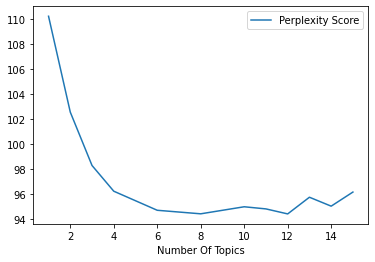

In [123]:
df_perplexity.plot.line("Number Of Topics", "Perplexity Score")

In [124]:
optimal_num_topics = 12

In [125]:
# define and fit LDA model

lda = sklearn.decomposition.LatentDirichletAllocation(
    n_components=optimal_num_topics,
    learning_method="online",
    random_state=0,
    n_jobs=-1
)
lda.fit(clean_vec1)

LatentDirichletAllocation(learning_method='online', n_components=12, n_jobs=-1,
                          random_state=0)

In [126]:
# output matrix
# h: docs to topics

lda_transform = lda.transform(clean_vec1)
#print(lda_transform.shape)
#print(lda_transform)

In [127]:
# output matrix
# w: words to topics

lda_components = lda.components_
#print(lda_components.shape)
#print(lda_components)

In [128]:
# define function to reformat output matrices into easily readable tables

def get_topics(mod, vec, names, docs, ndocs, nwords):
    # word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, numpy.newaxis]
    # topic to document matrix
    H = mod.transform(vec)
    
    W_dict = {}
    H_dict = {}
    
    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = "Topic{}".format(tpc_idx)
        
        # formatting w
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [
            (round(tpc_val[j], 4), names[j]) 
            for j in W_indices
        ]
        W_dict[topic] = W_names_values
        
        # formatting h
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [
            (round(H[:, tpc_idx][j], 4), docs[j]) 
            for j in H_indices
        ]
        H_dict[topic] = H_names_values
        
    W_df = pandas.DataFrame(
        W_dict, 
        index=["Word" + str(i) for i in range(nwords)]
    )
    H_df = pandas.DataFrame(
        H_dict,
        index=["Doc" + str(i) for i in range(ndocs)]
    )
        
    return (W_df, H_df)

In [130]:
# run function

W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

KeyError: 1832

In [ ]:
# word-topic table
print(W_df)

In [ ]:
# document-topic table
print(H_df)

### Visualizing LDA

In [ ]:
# iterative visualization
# featuring pca biplot and histogram
lda_plot = pyLDAvis.sklearn.prepare(lda, clean_vec1, vectorizer1, R=10)
pyLDAvis.save_html(lda_plot, 'report/lda.html')
pyLDAvis.display(lda_plot)

In [ ]:
# define functiont to fit and plot t-SNE model

def plot_tsne(data, threshold):
    # filter data according to threshold
    index_meet_threshold = numpy.amax(data, axis=1) >= threshold
    lda_transform_filt = data[index_meet_threshold]
    
    # fit tsne model
    # x-d -> 2-d, x = number of topics
    tsne = sklearn.manifold.TSNE(
        n_components=2, 
        verbose=0, 
        random_state=0, 
        angle=0.5, 
        init='pca'
    )
    tsne_fit = tsne.fit_transform(lda_transform_filt)
    
    # most probable topic for each headline
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(lda_transform_filt[i].argmax())
    
    print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = numpy.unique(
        numpy.array(most_prob_topic), 
        return_counts=True
    )

    print("COUNTS:\n{}\n".format(numpy.asarray((unique, counts)).T))
    
    # make plot
    matplotlib.pyplot.figure(figsize=(15,10))
    #color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r']
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    for i in list(set(most_prob_topic)):
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        matplotlib.pyplot.scatter(
            x=tsne_fit[indices, 0], 
            y=tsne_fit[indices, 1], 
            s=0.5, 
            c=color_list[i], 
            label='Topic' + str(i),
            alpha=1
        )
    
    
    matplotlib.pyplot.xlabel('x-tsne')
    matplotlib.pyplot.ylabel('y-tsne')
    matplotlib.pyplot.legend(markerscale=5)

In [ ]:
plot_tsne(data=lda_transform, threshold=0)

In [ ]:
# define and fit nmf model

nmf = sklearn.decomposition.NMF(
    n_components=optimal_num_topics,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    alpha=0.1, 
    l1_ratio=0.5
)
nmf.fit(clean_vec1)

In [ ]:
# run function to produce nice output tables

W_df, H_df = get_topics(
    mod=nmf,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

In [ ]:
# word-topic table
print(W_df)

In [ ]:
# document-topic table
print(H_df)

In [ ]:
# output raw document-topic matrix for t-SNE plot
nmf_transform = nmf.transform(clean_vec1)
print(nmf_transform.shape)
print(nmf_transform)

In [ ]:
# run function to produce t-SNE plot
plot_tsne(data=nmf_transform, threshold=0)